## 1. Import Libraries

In [11]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
try:
    import community.community_louvain as community_louvain
except ImportError:
    import community as community_louvain  # fallback for older versions
from networkx.algorithms import community as nx_community
import warnings

warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 11

print('✓ All libraries imported successfully')

✓ All libraries imported successfully


## 2. Load Graph from GML File

In [12]:
# Load the graph generated by the previous notebook
gml_path = '../data/cyber_attacks_graph.gml'
G = nx.read_gml(gml_path)

print(f'✓ Graph loaded from {gml_path}')
print(f'\nGraph Overview:')
print(f'  - Type: {"Directed" if G.is_directed() else "Undirected"}')
print(f'  - Nodes (countries): {G.number_of_nodes()}')
print(f'  - Edges (attack routes): {G.number_of_edges()}')
print(f'  - Total attacks: {sum(d["weight"] for u, v, d in G.edges(data=True)):.0f}')
print(f'  - Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}')
print(f'  - Network density: {nx.density(G):.4f}')

✓ Graph loaded from ../data/cyber_attacks_graph.gml

Graph Overview:
  - Type: Directed
  - Nodes (countries): 217
  - Edges (attack routes): 4332
  - Total attacks: 74096
  - Average degree: 39.93
  - Network density: 0.0924


## 3. Basic Graph Visualization

Computing graph layout...


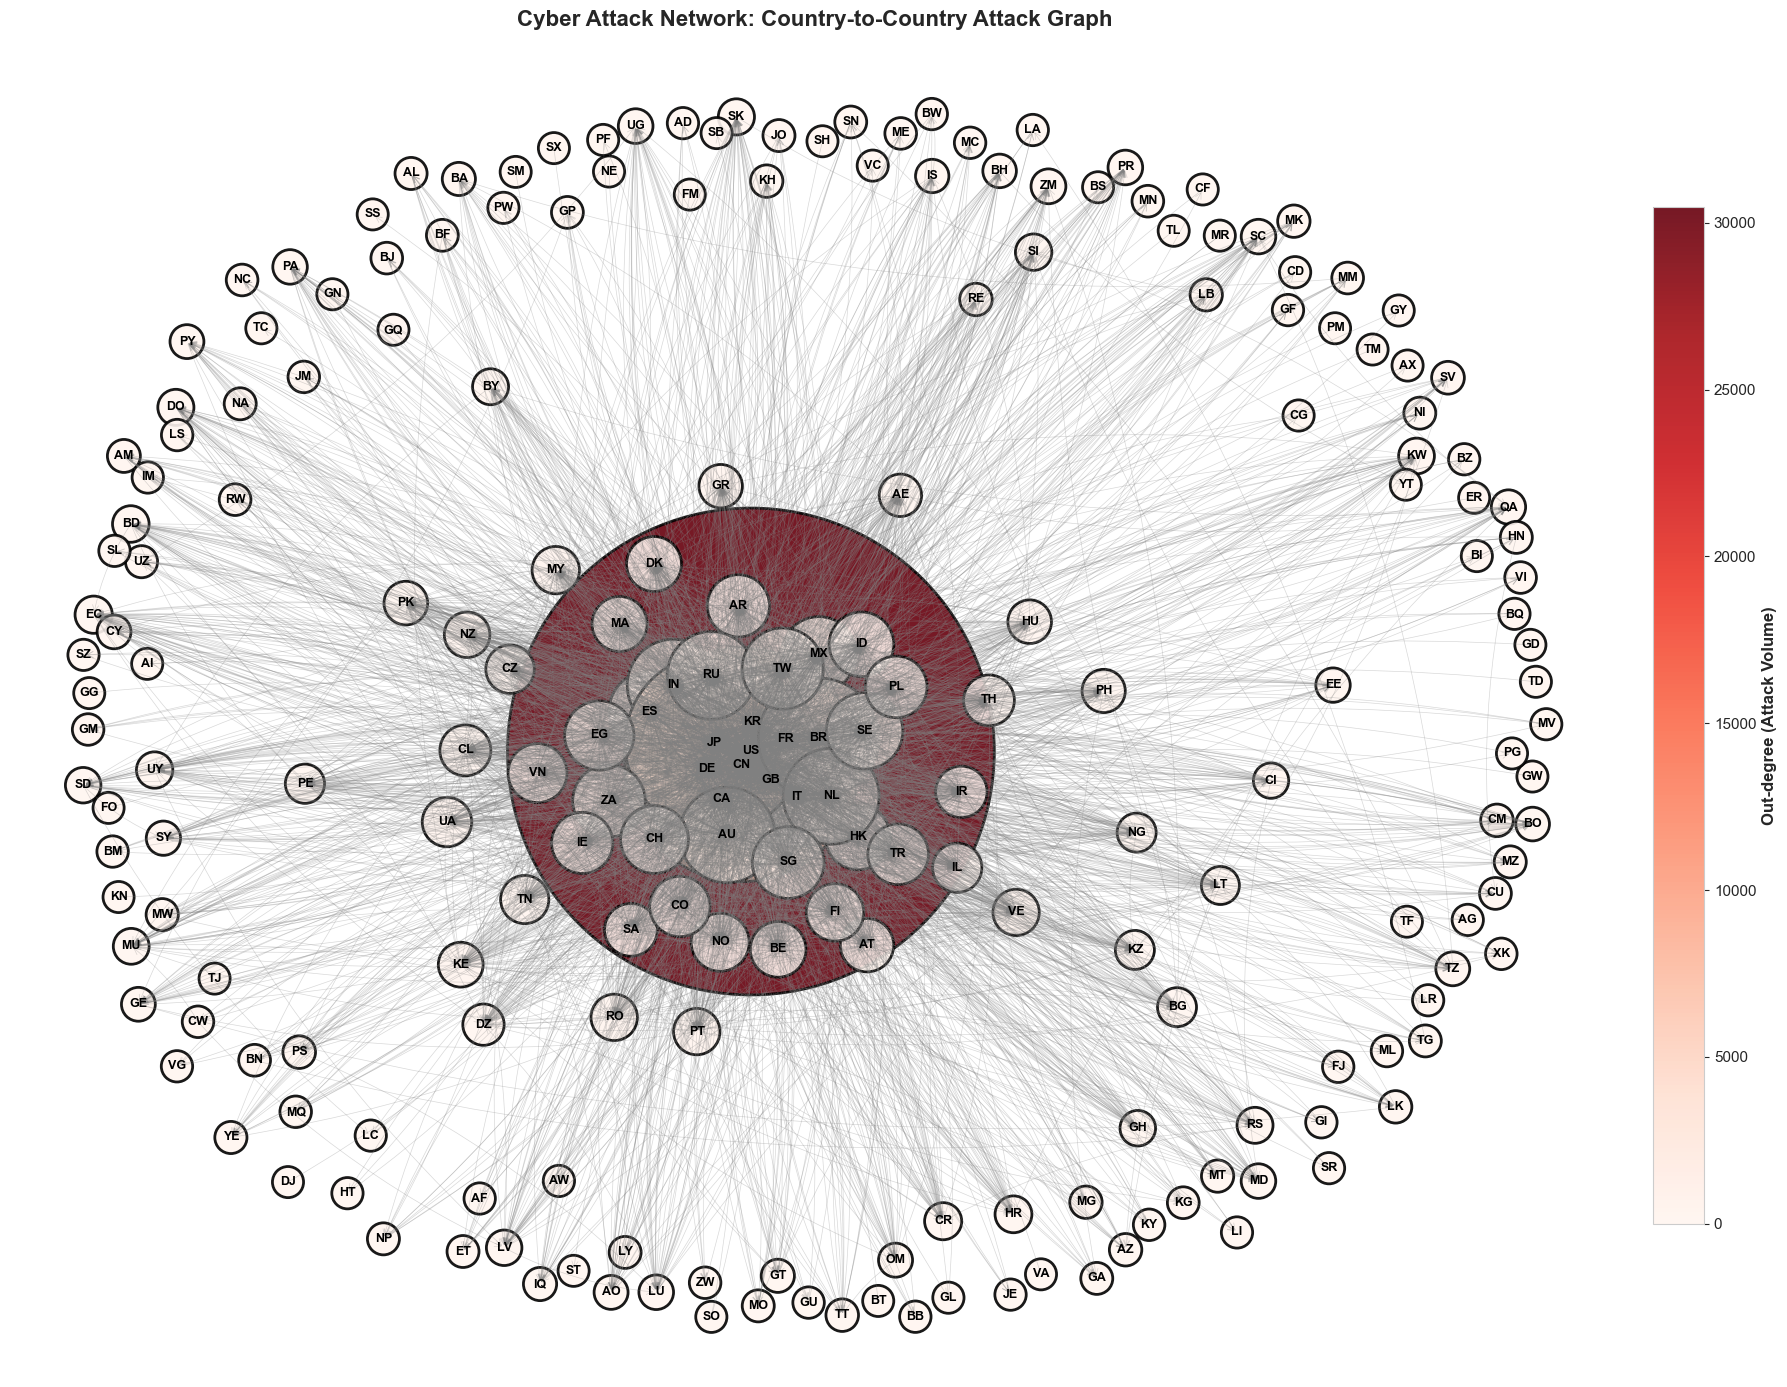

✓ Graph visualization complete


In [13]:
# Compute layout (spring layout for better visualization)
print('Computing graph layout...')
pos = nx.spring_layout(G, k=2, iterations=50, seed=42, weight='weight')

# Compute node metrics
in_degrees = dict(G.in_degree(weight='weight'))
out_degrees = dict(G.out_degree(weight='weight'))
total_degrees = {n: in_degrees.get(n, 0) + out_degrees.get(n, 0) for n in G.nodes()}

# Node size based on total degree (prominence in the network)
node_sizes = [500 + total_degrees[n] * 2 for n in G.nodes()]
node_colors = [out_degrees[n] for n in G.nodes()]

# Create visualization
fig, ax = plt.subplots(figsize=(18, 14))

# Draw edges with varying width and transparency
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
max_weight = max(weights)
edge_widths = [0.5 + (w / max_weight) * 3 for w in weights]
edge_alphas = [0.3 + (w / max_weight) * 0.5 for w in weights]

for (u, v), width, alpha in zip(edges, edge_widths, edge_alphas):
    ax.annotate('',
                xy=pos[v], xycoords='data',
                xytext=pos[u], textcoords='data',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1',
                               lw=width, alpha=alpha, color='gray'))

# Draw nodes
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.Reds,
    alpha=0.9,
    edgecolors='black',
    linewidths=2,
    ax=ax
)

# Draw labels
nx.draw_networkx_labels(
    G, pos,
    font_size=9,
    font_weight='bold',
    font_color='black',
    ax=ax
)

# Add colorbar
cbar = plt.colorbar(nodes, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label('Out-degree (Attack Volume)', fontsize=12, fontweight='bold')

plt.title('Cyber Attack Network: Country-to-Country Attack Graph', 
         fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

print('✓ Graph visualization complete')

## 4. Centrality Analysis

In [14]:
print('Computing centrality measures...\n')

# Degree centrality
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)

# Betweenness centrality (nodes that act as bridges)
betweenness = nx.betweenness_centrality(G, weight='weight')

# PageRank (importance based on incoming connections)
pagerank = nx.pagerank(G, weight='weight')

# Create centrality DataFrame
centrality_df = pd.DataFrame({
    'country': list(G.nodes()),
    'in_degree': [in_degrees[n] for n in G.nodes()],
    'out_degree': [out_degrees[n] for n in G.nodes()],
    'total_degree': [total_degrees[n] for n in G.nodes()],
    'betweenness': [betweenness[n] for n in G.nodes()],
    'pagerank': [pagerank[n] for n in G.nodes()]
})

centrality_df = centrality_df.sort_values('total_degree', ascending=False)

print('Top 10 Countries by Total Degree (Most Connected):')
print(centrality_df.head(10)[['country', 'in_degree', 'out_degree', 'total_degree']].to_string(index=False))

print('\nTop 10 Countries by Betweenness Centrality (Bridge Nodes):')
top_betweenness = centrality_df.nlargest(10, 'betweenness')[['country', 'betweenness']]
print(top_betweenness.to_string(index=False))

print('\nTop 10 Countries by PageRank (Influence):')
top_pagerank = centrality_df.nlargest(10, 'pagerank')[['country', 'pagerank']]
print(top_pagerank.to_string(index=False))

Computing centrality measures...

Top 10 Countries by Total Degree (Most Connected):
country  in_degree  out_degree  total_degree
     US      30722       30469         61191
     CN       6873        7055         13928
     JP       4034        4040          8074
     DE       2665        2700          5365
     GB       2687        2649          5336
     KR       2376        2357          4733
     BR       1736        1782          3518
     FR       1665        1659          3324
     CA       1503        1486          2989
     IT       1165        1158          2323

Top 10 Countries by Betweenness Centrality (Bridge Nodes):
country  betweenness
     US     0.151378
     CN     0.085304
     DE     0.075559
     JP     0.043927
     BR     0.037380
     GB     0.035558
     KR     0.035130
     FR     0.034106
     NL     0.027195
     CA     0.026928

Top 10 Countries by PageRank (Influence):
country  pagerank
     US  0.349394
     CN  0.081248
     JP  0.045807
     DE  0.033

## 5. Community Detection - Louvain Method

In [15]:
print('Running Louvain community detection...\n')

# Convert to undirected for community detection
G_undirected = G.to_undirected()

# Louvain method (best modularity optimization)
louvain_communities = community_louvain.best_partition(G_undirected, weight='weight')

# Calculate modularity
modularity = community_louvain.modularity(louvain_communities, G_undirected, weight='weight')

# Count communities
n_communities = len(set(louvain_communities.values()))

print(f'✓ Louvain Community Detection Results:')
print(f'  - Number of communities: {n_communities}')
print(f'  - Modularity score: {modularity:.4f}')

# Organize communities
communities_dict = {}
for node, comm_id in louvain_communities.items():
    if comm_id not in communities_dict:
        communities_dict[comm_id] = []
    communities_dict[comm_id].append(node)

print(f'\nCommunity Sizes:')
for comm_id, members in sorted(communities_dict.items(), key=lambda x: len(x[1]), reverse=True):
    print(f'  Community {comm_id}: {len(members)} countries')
    print(f'    Members: {", ".join(sorted(members))}')

Running Louvain community detection...

✓ Louvain Community Detection Results:
  - Number of communities: 2
  - Modularity score: 0.0982

Community Sizes:
  Community 0: 181 countries
    Members: AD, AE, AG, AL, AM, AO, AR, AT, AU, AX, AZ, BA, BB, BD, BE, BF, BG, BH, BI, BJ, BM, BN, BO, BQ, BR, BS, BT, BW, BY, BZ, CA, CF, CH, CI, CL, CM, CN, CO, CR, CU, CW, CZ, DE, DJ, DK, DO, DZ, EC, EE, EG, ER, ES, ET, FI, FJ, FM, FR, GA, GB, GE, GH, GI, GL, GM, GN, GP, GQ, GR, GT, GU, GW, HK, HN, HR, HU, ID, IE, IL, IM, IN, IQ, IR, IS, IT, JE, JM, JP, KE, KG, KH, KR, KW, KY, KZ, LA, LB, LC, LI, LK, LR, LT, LU, LV, MA, MC, MD, ME, MG, MK, MM, MN, MO, MQ, MT, MU, MV, MW, MX, MY, MZ, NA, NG, NI, NL, NO, NP, NZ, OM, PA, PE, PH, PK, PL, PR, PS, PT, PY, QA, RE, RO, RS, RU, RW, SA, SC, SD, SE, SG, SH, SI, SK, SL, SM, SN, SS, SV, SY, TF, TG, TH, TJ, TL, TN, TR, TT, TW, TZ, UA, UG, UY, UZ, VE, VG, VI, VN, XK, YE, YT, ZA, ZM, ZW
  Community 1: 36 countries
    Members: AF, AI, AW, CD, CG, CY, FO, GD, GF, GG,

## 6. Visualize Communities

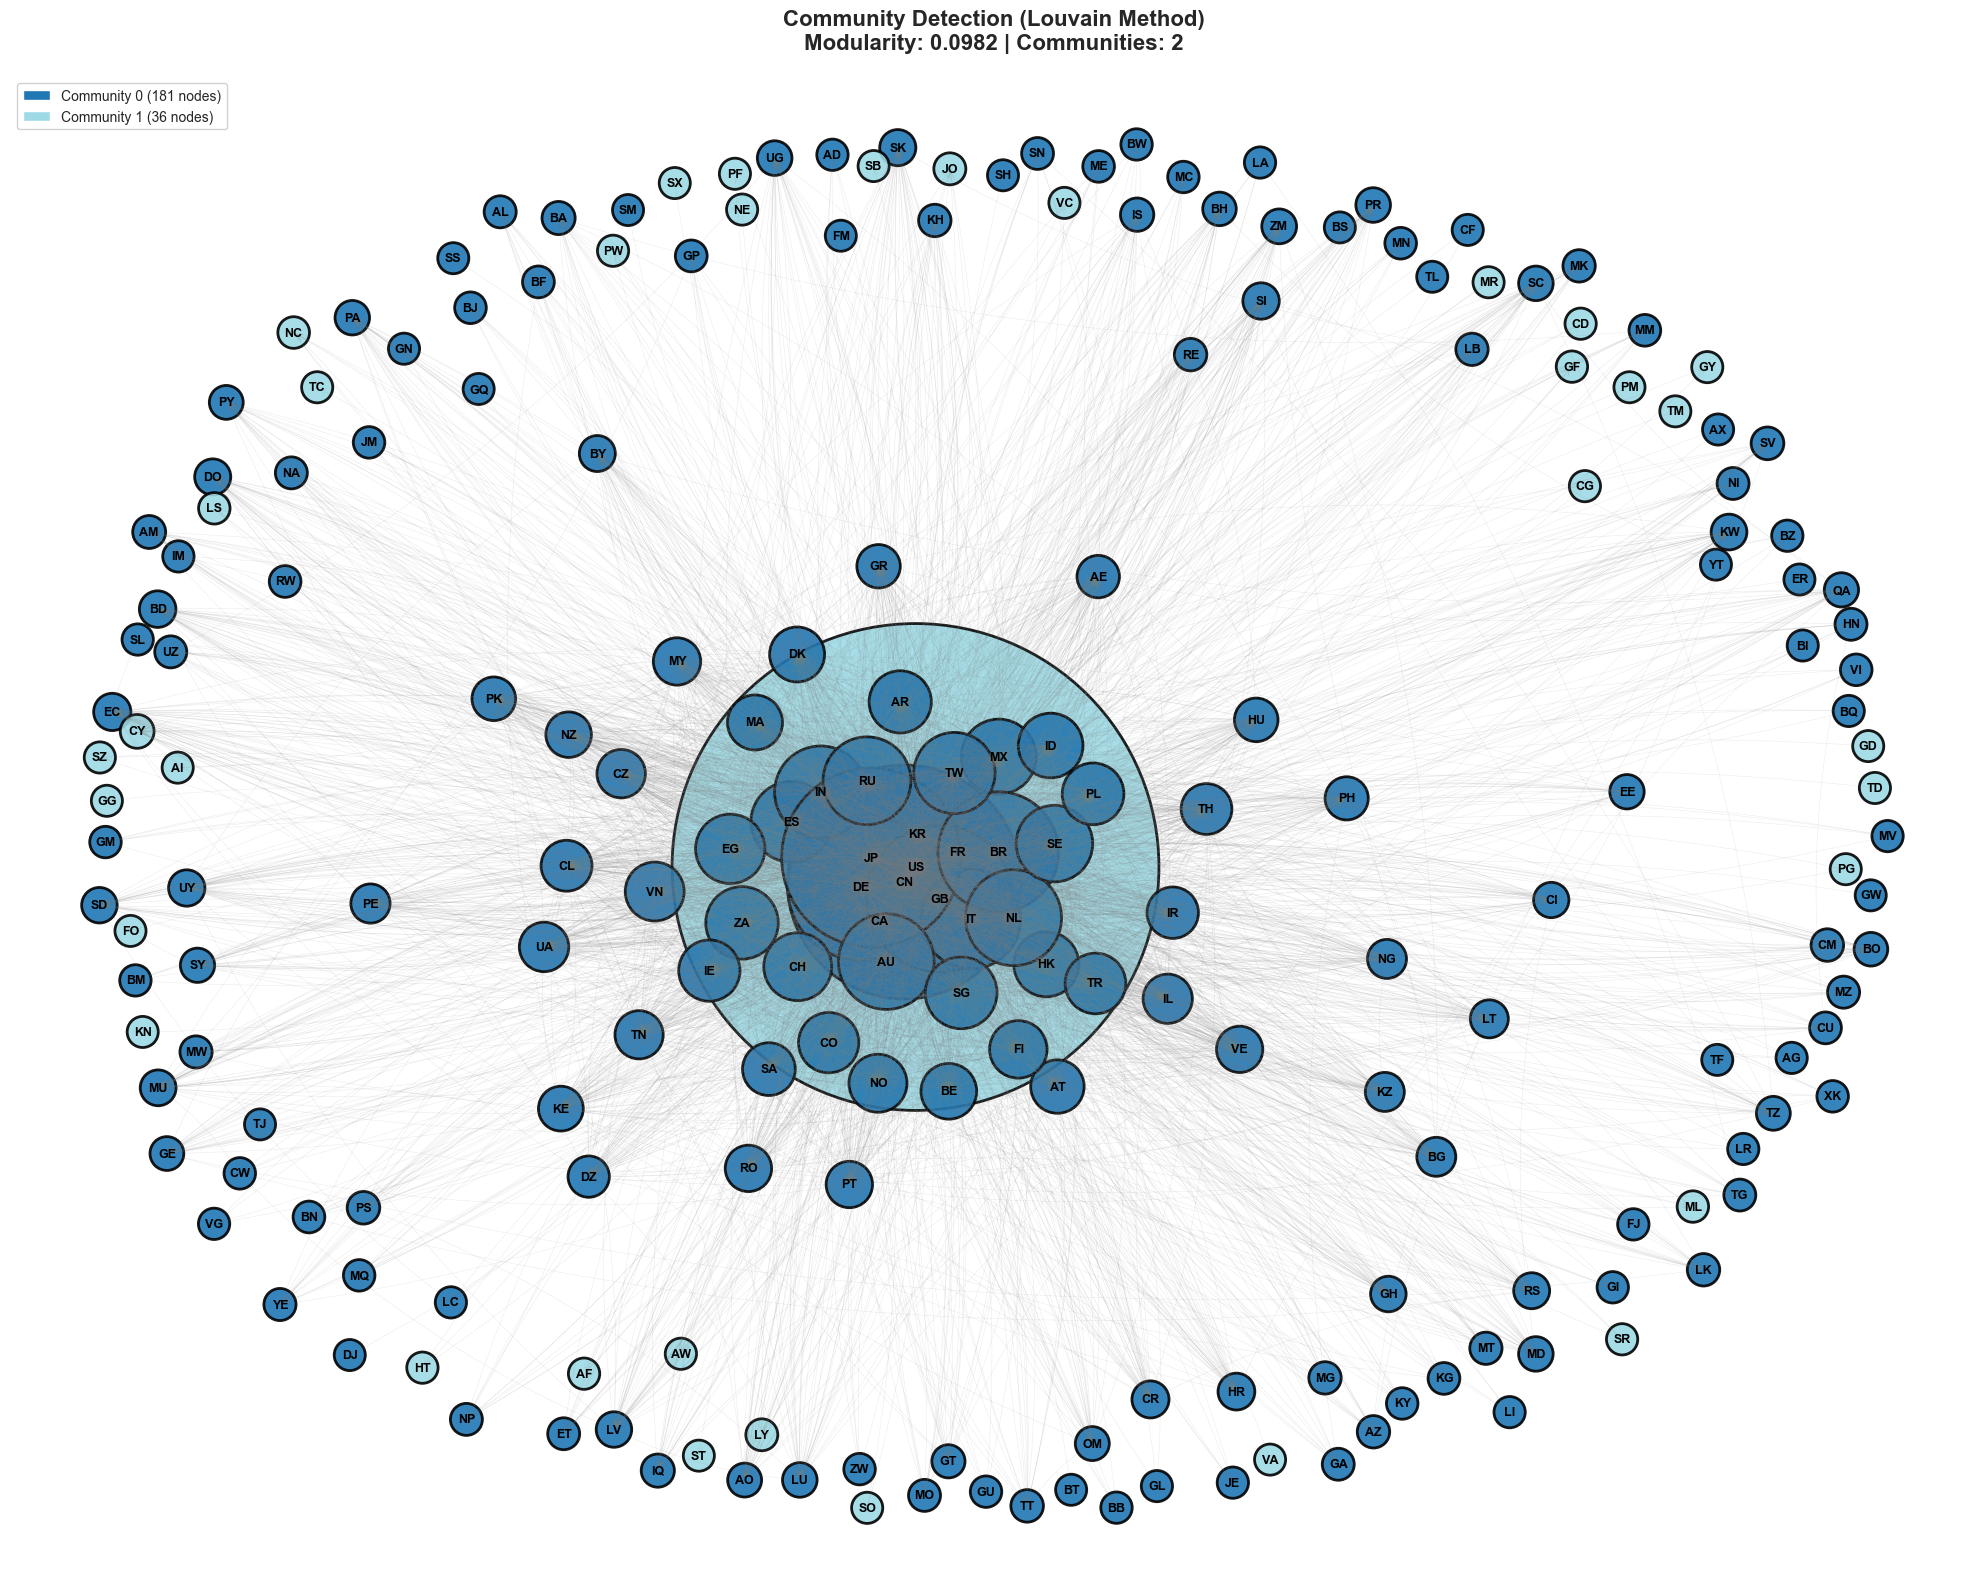

✓ Community visualization complete


In [22]:
# Create color map for communities
n_communities = len(set(louvain_communities.values()))
colors = plt.cm.tab20(np.linspace(0, 1, n_communities))
community_colors = [colors[louvain_communities[node]] for node in G.nodes()]

# Visualize with communities
fig, ax = plt.subplots(figsize=(20, 16))

# Draw edges
for (u, v), width, alpha in zip(edges, edge_widths, edge_alphas):
    ax.annotate('',
                xy=pos[v], xycoords='data',
                xytext=pos[u], textcoords='data',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1',
                               lw=width * 0.8, alpha=alpha * 0.5, color='gray'))

# Draw nodes colored by community
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=community_colors,
    alpha=0.9,
    edgecolors='black',
    linewidths=2,
    ax=ax
)

# Draw labels
nx.draw_networkx_labels(
    G, pos,
    font_size=9,
    font_weight='bold',
    font_color='black',
    ax=ax
)

# Add legend for communities
legend_elements = []
for comm_id in sorted(communities_dict.keys()):
    legend_elements.append(
        Rectangle((0, 0), 1, 1, fc=colors[comm_id], label=f'Community {comm_id} ({len(communities_dict[comm_id])} nodes)')
    )

ax.legend(handles=legend_elements, loc='upper left', fontsize=10, framealpha=0.9)

plt.title(f'Community Detection (Louvain Method)\nModularity: {modularity:.4f} | Communities: {n_communities}',
         fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

print('✓ Community visualization complete')

## 7. Alternative Community Detection Methods

In [23]:
print('Comparing different community detection algorithms...\n')

# Label Propagation
print('Running Label Propagation...')
label_prop_communities = list(nx_community.label_propagation_communities(G_undirected))
n_lp_communities = len(label_prop_communities)
print(f'  - Label Propagation found {n_lp_communities} communities')

# Greedy Modularity
print('Running Greedy Modularity Optimization...')
greedy_communities = list(nx_community.greedy_modularity_communities(G_undirected, weight='weight'))
n_greedy_communities = len(greedy_communities)
greedy_modularity = nx_community.modularity(G_undirected, greedy_communities, weight='weight')
print(f'  - Greedy Modularity found {n_greedy_communities} communities (modularity: {greedy_modularity:.4f})')

print(f'\nComparison Summary:')
print(f'  - Louvain: {n_communities} communities, modularity: {modularity:.4f}')
print(f'  - Label Propagation: {n_lp_communities} communities')
print(f'  - Greedy Modularity: {n_greedy_communities} communities, modularity: {greedy_modularity:.4f}')

print(f'\n✓ Best method: Louvain (highest modularity)' if modularity >= greedy_modularity else f'\n✓ Best method: Greedy Modularity')

Comparing different community detection algorithms...

Running Label Propagation...
  - Label Propagation found 1 communities
Running Greedy Modularity Optimization...
  - Greedy Modularity found 2 communities (modularity: 0.0982)

Comparison Summary:
  - Louvain: 2 communities, modularity: 0.0982
  - Label Propagation: 1 communities
  - Greedy Modularity: 2 communities, modularity: 0.0982

✓ Best method: Louvain (highest modularity)


## 8. Analyze Subgraphs by Community

In [24]:
print('Analyzing subgraphs for each community...\n')

community_stats = []

for comm_id, members in sorted(communities_dict.items(), key=lambda x: len(x[1]), reverse=True):
    # Extract subgraph
    subgraph = G.subgraph(members)
    
    # Calculate statistics
    n_nodes = subgraph.number_of_nodes()
    n_edges = subgraph.number_of_edges()
    total_weight = sum(d['weight'] for u, v, d in subgraph.edges(data=True))
    density = nx.density(subgraph)
    
    # Internal vs external edges
    internal_edges = n_edges
    external_edges = sum(1 for u in members for v in G.successors(u) if v not in members)
    
    community_stats.append({
        'community_id': comm_id,
        'nodes': n_nodes,
        'internal_edges': internal_edges,
        'external_edges': external_edges,
        'total_attacks': total_weight,
        'density': density,
        'members': ', '.join(sorted(members)[:10]) + ('...' if len(members) > 10 else '')
    })
    
    print(f'Community {comm_id}:')
    print(f'  - Nodes: {n_nodes}')
    print(f'  - Internal edges: {internal_edges}')
    print(f'  - External edges: {external_edges}')
    print(f'  - Total attacks: {total_weight:.0f}')
    print(f'  - Density: {density:.4f}')
    print(f'  - Top members: {", ".join(sorted(members)[:5])}')
    print()

# Create summary DataFrame
community_summary = pd.DataFrame(community_stats)
print('\nCommunity Summary Table:')
print(community_summary.to_string(index=False))

Analyzing subgraphs for each community...

Community 0:
  - Nodes: 181
  - Internal edges: 3924
  - External edges: 176
  - Total attacks: 25474
  - Density: 0.1204
  - Top members: AD, AE, AG, AL, AM

Community 1:
  - Nodes: 36
  - Internal edges: 49
  - External edges: 183
  - Total attacks: 12737
  - Density: 0.0389
  - Top members: AF, AI, AW, CD, CG


Community Summary Table:
 community_id  nodes  internal_edges  external_edges  total_attacks  density                                   members
            0    181            3924             176          25474 0.120442 AD, AE, AG, AL, AM, AO, AR, AT, AU, AX...
            1     36              49             183          12737 0.038889 AF, AI, AW, CD, CG, CY, FO, GD, GF, GG...


## 9. Visualize Individual Community Subgraphs

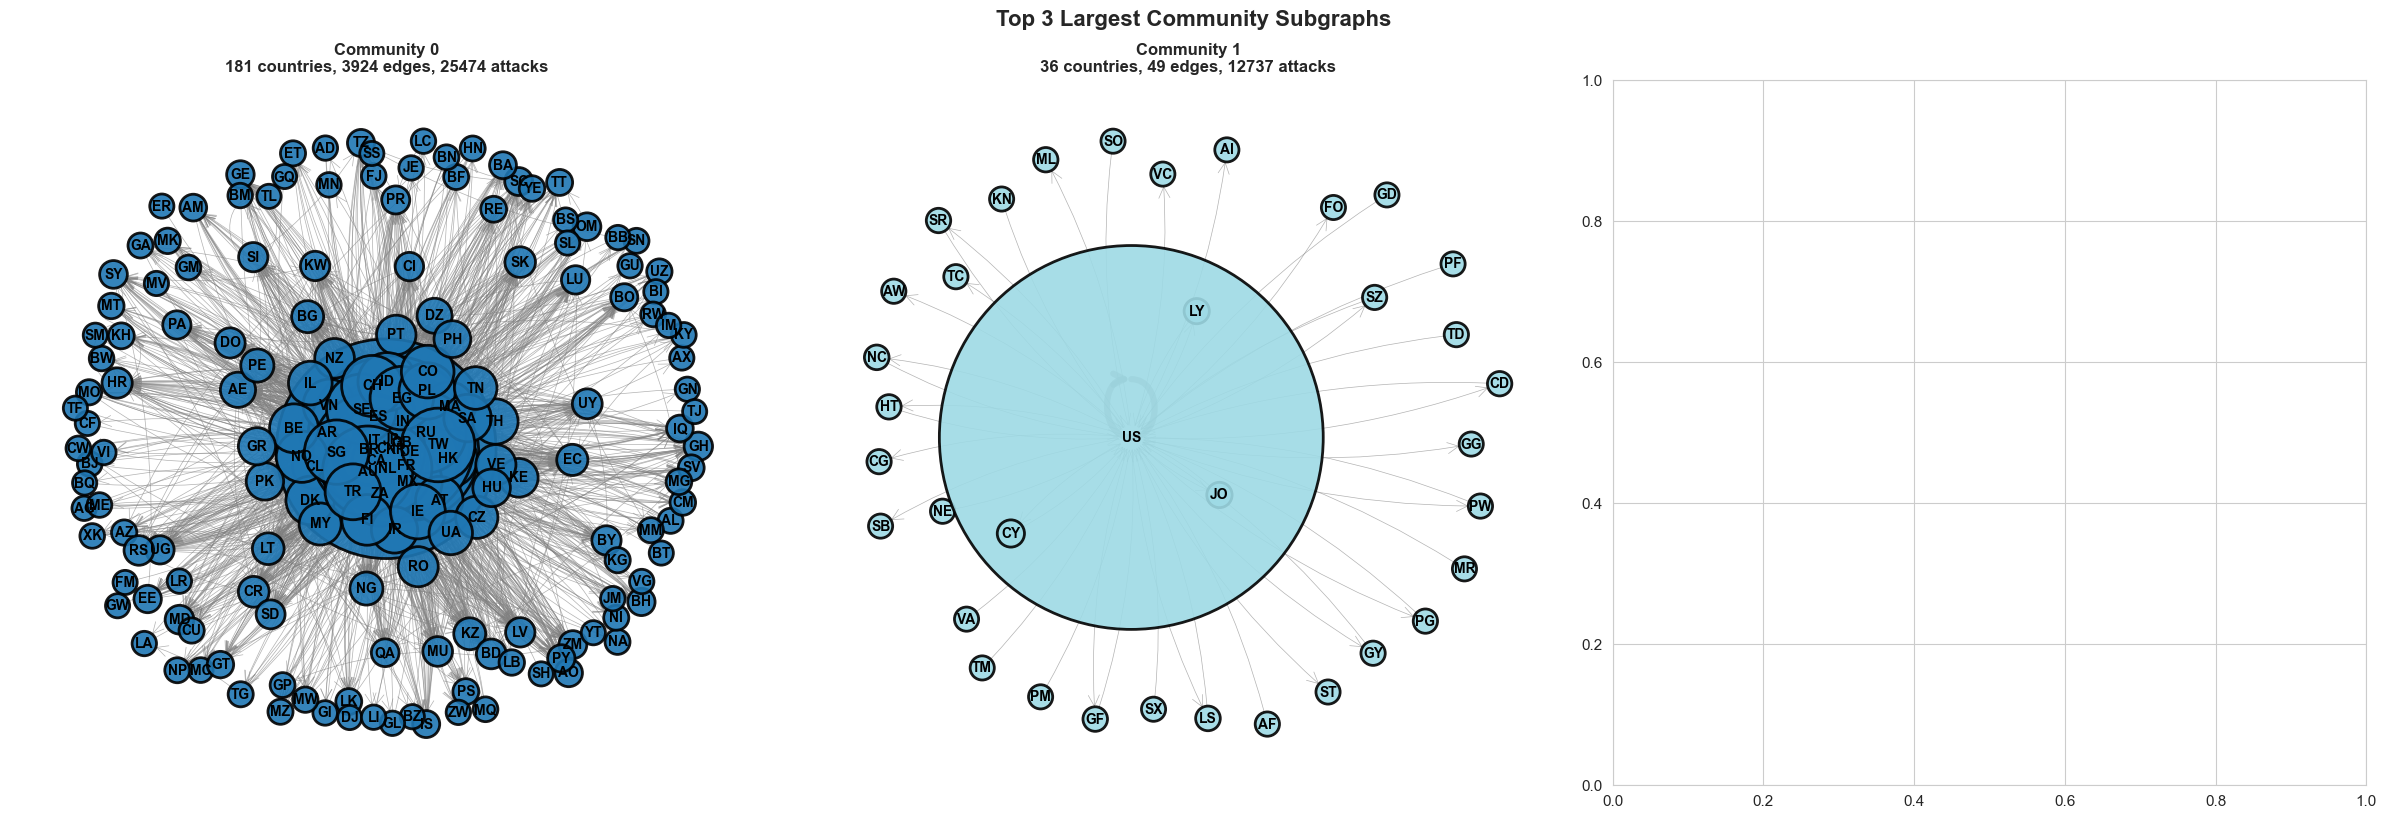

✓ Community subgraph visualization complete


In [25]:
# Visualize the 3 largest communities as separate subgraphs
top_communities = sorted(communities_dict.items(), key=lambda x: len(x[1]), reverse=True)[:3]

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for idx, (comm_id, members) in enumerate(top_communities):
    ax = axes[idx]
    
    # Extract subgraph
    subgraph = G.subgraph(members).copy()
    
    # Layout for this subgraph
    sub_pos = nx.spring_layout(subgraph, k=1.5, iterations=50, seed=42, weight='weight')
    
    # Node sizes based on degree within community
    sub_degrees = dict(subgraph.degree(weight='weight'))
    sub_node_sizes = [300 + sub_degrees[n] * 3 for n in subgraph.nodes()]
    
    # Draw edges
    sub_edges = list(subgraph.edges())
    sub_weights = [subgraph[u][v]['weight'] for u, v in sub_edges]
    max_sub_weight = max(sub_weights) if sub_weights else 1
    sub_edge_widths = [0.5 + (w / max_sub_weight) * 4 for w in sub_weights]
    
    nx.draw_networkx_edges(
        subgraph, sub_pos,
        width=sub_edge_widths,
        edge_color='gray',
        alpha=0.6,
        arrows=True,
        arrowsize=20,
        arrowstyle='->',
        connectionstyle='arc3,rad=0.1',
        ax=ax
    )
    
    # Draw nodes
    nx.draw_networkx_nodes(
        subgraph, sub_pos,
        node_size=sub_node_sizes,
        node_color=colors[comm_id],
        alpha=0.9,
        edgecolors='black',
        linewidths=2,
        ax=ax
    )
    
    # Draw labels
    nx.draw_networkx_labels(
        subgraph, sub_pos,
        font_size=10,
        font_weight='bold',
        ax=ax
    )
    
    total_attacks = sum(d['weight'] for u, v, d in subgraph.edges(data=True))
    ax.set_title(f'Community {comm_id}\n{len(members)} countries, {subgraph.number_of_edges()} edges, {total_attacks:.0f} attacks',
                fontsize=12, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.suptitle('Top 3 Largest Community Subgraphs', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print('✓ Community subgraph visualization complete')

## 10. Export Results

In [26]:
# Export community assignments
community_df = pd.DataFrame([
    {'country': node, 'community': comm_id}
    for node, comm_id in louvain_communities.items()
])
community_df = community_df.sort_values(['community', 'country'])

output_path = '../data/community_assignments.csv'
community_df.to_csv(output_path, index=False)
print(f'✓ Community assignments saved to {output_path}')

# Export centrality measures
centrality_output = '../data/node_centrality_metrics.csv'
centrality_df.to_csv(centrality_output, index=False)
print(f'✓ Centrality metrics saved to {centrality_output}')

# Export community statistics
community_stats_output = '../data/community_statistics.csv'
community_summary.to_csv(community_stats_output, index=False)
print(f'✓ Community statistics saved to {community_stats_output}')

print('\n✓ All results exported successfully!')

✓ Community assignments saved to ../data/community_assignments.csv
✓ Centrality metrics saved to ../data/node_centrality_metrics.csv
✓ Community statistics saved to ../data/community_statistics.csv

✓ All results exported successfully!


## 11. Summary Report

In [27]:
print('\n' + '='*70)
print('GRAPH ANALYSIS & COMMUNITY DETECTION SUMMARY')
print('='*70)

print(f'\nGraph Statistics:')
print(f'  - Total countries (nodes): {G.number_of_nodes()}')
print(f'  - Total attack routes (edges): {G.number_of_edges()}')
print(f'  - Network density: {nx.density(G):.4f}')
print(f'  - Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}')

print(f'\nCommunity Detection (Louvain):')
print(f'  - Number of communities: {n_communities}')
print(f'  - Modularity score: {modularity:.4f}')
print(f'  - Largest community size: {max(len(m) for m in communities_dict.values())} countries')
print(f'  - Smallest community size: {min(len(m) for m in communities_dict.values())} countries')

print(f'\nTop 3 Most Connected Countries:')
for idx, row in centrality_df.head(3).iterrows():
    print(f'  {row["country"]}: {row["total_degree"]:.0f} total attacks (in: {row["in_degree"]:.0f}, out: {row["out_degree"]:.0f})')

print(f'\nTop 3 Bridge Countries (Highest Betweenness):')
for idx, row in centrality_df.nlargest(3, 'betweenness').iterrows():
    print(f'  {row["country"]}: {row["betweenness"]:.4f}')

print('\n' + '='*70)
print('✓ Analysis complete!')
print('='*70)


GRAPH ANALYSIS & COMMUNITY DETECTION SUMMARY

Graph Statistics:
  - Total countries (nodes): 217
  - Total attack routes (edges): 4332
  - Network density: 0.0924
  - Average degree: 39.93

Community Detection (Louvain):
  - Number of communities: 2
  - Modularity score: 0.0982
  - Largest community size: 181 countries
  - Smallest community size: 36 countries

Top 3 Most Connected Countries:
  US: 61191 total attacks (in: 30722, out: 30469)
  CN: 13928 total attacks (in: 6873, out: 7055)
  JP: 8074 total attacks (in: 4034, out: 4040)

Top 3 Bridge Countries (Highest Betweenness):
  US: 0.1514
  CN: 0.0853
  DE: 0.0756

✓ Analysis complete!
